In [92]:
import numpy as np
import matplotlib.pyplot as plt
from diskfit import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
from diskfit import likelihood, utils
from scipy.optimize import minimize

%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
#import mechanize
#from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

import tqdm

import warnings
from astropy.units import UnitsWarning

In [93]:
# Decomposed values
FE_S0 = 26.98101902  
FE_INDEX0 = 39.58118213  
FE_SHIFT0 = 0.02259045495  
SB_S0 = 6.286910627  
SB_INDEX0 = 7  
SB_SHIFT0 = 0.01506175323 




# Templates
feii_template_path='/home/serat/Downloads/fe_op_templates.npy'
stellar_template_path='/home/serat/Downloads/PyQSOfit_MILES_templates.dat'
balmer_cont_template_path='/home/serat/Downloads/balmer_cont_templates.npy'
balmer_highorder_template_path='/home/serat/Downloads/balmer_highorder_templates.npy'

num_templates_feii=100
num_templates_host=8
num_templates_balmer_cont=20
num_templates_balmer_highorder=21

feii_templates=np.load(feii_template_path,allow_pickle=True)
stellar_templates=np.genfromtxt(stellar_template_path,skip_header=5)
balmer_cont_templates=np.load(balmer_cont_template_path,allow_pickle=True)
balmer_highorder_templates=np.load(balmer_highorder_template_path,allow_pickle=True)

In [94]:
# Functions for new spectra

def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power


def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [95]:
# Integration, units, normalization

maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]
# Circular disk size and emission properties

q1 = 1.4 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-7   # optical depth normalization (0=no wind)
eta = 0. #optical depth power-law index
anglam = 15 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms 7
amp = 0 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 250 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = 310 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 77 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)

#Narrow lines
narrowwidth = 4.0 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 2.5 # Width of component 2 of broad line in Angstroms
narrowfrac = 1.0 #Amplitude fraction the two narrow line components


NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
NIIb_NIIa = 4.8
SIIb_SIIa = 0.7
OIb_OIa = 0.33
ratios = [NIIb_NIIa,SIIb_SIIa,OIb_OIa]

olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
#wavemin = 6300  # minimum rest wavelength (Angstrom)
#wavemax = 6900  # maximum rest wavelength (Angstrom)
#wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
#indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
#wl = np.asarray(wl[indwave],dtype=np.float64)
#flux = flux[indwave]
#fluxerr = fluxerr[indwave]


# Bounds on parameters
angimax = 360                                                                       
angimin= -360                                                                       
xi1min = 10                                                                         
xi1max = 2000                                                                       
xi2min = 100                                                                        
xi2max = 4000                                                                       
broadmin = 0                                                                        
broadmax = 3000                                                                                                                                            
ampmin = 0.0                                                                        
ampmax = 8.0                                                                        
pitchmin = -60                                                                      
pitchmax = 60                                                                       
aobsmin = -720                                                                      
aobsmax = 360*3 
narrowwidthmin=0
narrowwidthmax=12.0
narrowwidth2min = 0
narrowwidth2max = 12.0
narrowfracmin = 0.01
narrowfracmax = 10

# DATA

In [96]:
SII1_F0 = 11.1721073
SII1_CENT0 = 6716.04314
SII1_FWHM0 = 393.5954679
SII2_F0 = 8.335673742
SII2_CENT0 = 6730.906927
SII2_FWHM0 = 393.5954679
NII1_F0 = 10.63741401
NII1_CENT0 = 6548.323235
NII1_FWHM0 = 393.5954679
NII2_F0 = 31.52318712
NII2_CENT0 = 6582.888789
NII2_FWHM0 = 393.5954679 
HALPHA1_F0 = 20.63047916
HALPHA1_CENT0 = 6562.187441
HALPHA1_FWHM0 = 393.5954679

OI1_F0 = 7.998443445  
OI1_CENT0 = 6300.416844  
OI1_FWHM0 = 393.5954679  
OI2_F0 = 2.666147815  
OI2_CENT0 = 6367.798683  
OI2_FWHM0 = 393.5954679 

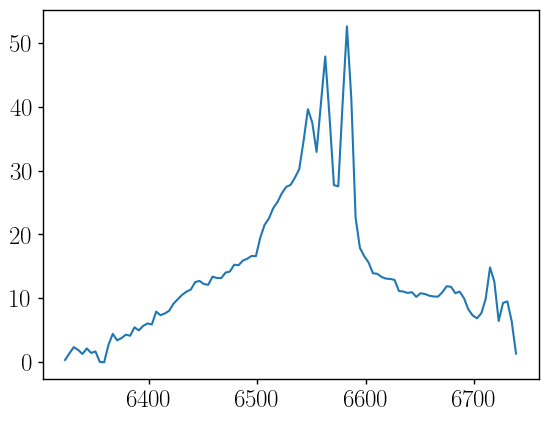

In [97]:
file_name = '/home/serat/Downloads/ticktock/bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 7500))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6015) | (wl_o > 6170))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130))
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]


coefficients = np.polyfit(wl, flux, 3)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

degree = 3

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o

file_path = '/home/serat/Downloads/ticktock/HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6320)&(source_wl<6740))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]

shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 4
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])


flux_halpha = source_flux / standard_flux
corrected_wl = bin_centers

rest_wavelength = 6564.93

c = 299792.458

vel_halpha = c * (corrected_wl - rest_wavelength) / rest_wavelength


pl = powerlaw(corrected_wl, 6.726822875, -0.9262954893 )

x = np.array(corrected_wl)

sii1 = gaussian(x,SII1_F0,SII1_CENT0,SII1_FWHM0,normalized=False)
sii2 = gaussian(x,SII2_F0,SII2_CENT0,SII2_FWHM0,normalized=False)

nii1 = gaussian(x,NII1_F0,NII1_CENT0,NII1_FWHM0,normalized=False)
nii2 = gaussian(x,NII2_F0,NII2_CENT0,NII2_FWHM0,normalized=False)

oi1 = gaussian(x,OI1_F0,OI1_CENT0,OI1_FWHM0,normalized=False)
oi2 = gaussian(x,OI2_F0,OI2_CENT0,OI2_FWHM0,normalized=False)

halpha = gaussian(x,HALPHA1_F0,HALPHA1_CENT0,HALPHA1_FWHM0,normalized=False)

npix = wl.shape[0]

flux_halpha = flux_halpha - pl #- (halpha + oi1 + oi2 + nii1 + nii2 + sii1 + sii2)
#narrow_lines = halpha + oi1 + oi2 + nii1 + nii2 + sii1 + sii2)

plt.plot(corrected_wl, flux_halpha)
plt.show()

In [98]:
wl,flux,fluxerr = corrected_wl*(1+z), flux_halpha, binned_err
z = 0.081
#narrowwidth = 4.5

wave = wl/(1+z)
npix = wl.shape[0]


# Hard coded values

mcmc_soln = [227.31482056523515, 1005.0982089936541, 2594.2683203246365, 24.04172235106259, 1.0003217529331654, 3.9637593339180635, 2.509285300364497]
amps_disk = 0.04172319059041423
amps_narrow = [17.4, 6.9, 4.51309816, 0.]
print(mcmc_soln)

[227.31482056523515, 1005.0982089936541, 2594.2683203246365, 24.04172235106259, 1.0003217529331654, 3.9637593339180635, 2.509285300364497]


In [99]:
soln = mcmc_soln # Or soln.x if you skipped running the full sampler.
narrowfrac = soln[4]
narrowwidth = soln[5]
narrowwidth2 = soln[6]


fixed_labels = ['amps_narrow','z','ratios','q1','q2','xib','maxstep','anglam','t0','eta','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix']
fixed_values = [amps_narrow,z,ratios,q1,q2,xib,maxstep,anglam,t0,eta,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix]
fixed = dict(zip(fixed_labels,fixed_values))


In [100]:

broad_center_min = 6400  
broad_center_max = 6700
broad_width_min = 10      
broad_width_max = 1000   
broad_amp_min = 0       
broad_amp_max = 1e4      


In [101]:
broad_center = 6563
broad_width = 50  
broad_amp = 7     
xi1  = soln[0] 
xi2 = soln[1]
broad = soln[2] # + 1700 
angi = soln[3]
fitted_labels = ['xi1','xi2','broad','angi','amps_disk',
                'broad_center', 'broad_width', 'broad_amp','narrowfrac','narrowwidth','narrowwidth2']
#initial = [xi1,xi2,broad,angi,amps_disk,
#          broad_center, broad_width,broad_amp,narrowfrac,narrowwidth,narrowwidth2]
initial=[5.06299986e+01,1.62155485e+03,1.96166656e+03,3.17920988e+01,5.61433836e-02,6.54979839e+03,3.25657420e+01,1.96098961e+01,
         1.58915602e+00,4.29307301e+00,5.00002059e-01]
print('Initial:', initial)
fitted = dict(zip(fitted_labels,initial))
diskmins = [xi1min,xi2min,broadmin,angimin,amps_disk*0.01,
           broad_center_min, broad_width_min, broad_amp_min,narrowfracmin,narrowwidthmin,narrowwidth2min]
diskmax = [xi1max,xi2max,broadmax,angimax,amps_disk*1e2,
          broad_center_max, broad_width_max, broad_amp_max,narrowfracmax,narrowwidthmax,narrowwidth2max]

Initial: [50.6299986, 1621.55485, 1961.66656, 31.7920988, 0.0561433836, 6549.79839, 32.565742, 19.6098961, 1.58915602, 4.29307301, 0.500002059]


In [102]:
modelguess, diskmodel, narrowmodel, broadmodel = likelihood.model_linefit_circ_fixeddoublet_freeamplitudes(initial, wl, flux, fluxerr, lines, fixed, fitted)

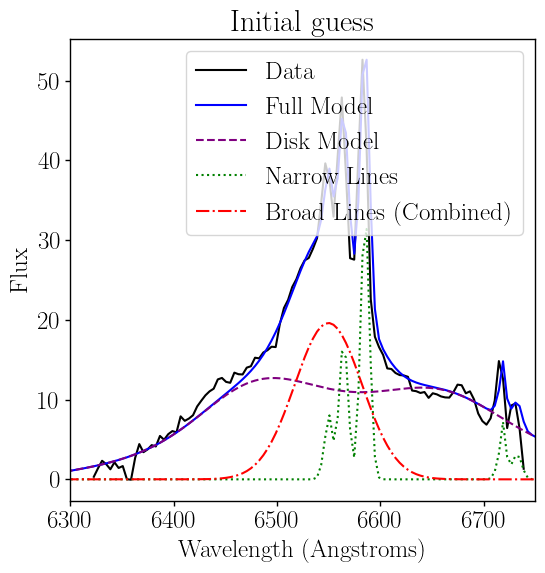

<Figure size 640x480 with 0 Axes>

In [103]:
plt.figure(figsize=(6,6))
plt.plot(wl / (1 + fixed['z']), flux, label='Data', color='black')
plt.plot(wl / (1 + fixed['z']), modelguess, label='Full Model', color='blue')
plt.plot(wl / (1 + fixed['z']), diskmodel, label='Disk Model', linestyle='--', color='purple')
plt.plot(wl / (1 + fixed['z']), narrowmodel, label='Narrow Lines', linestyle=':', color='green')
plt.plot(wl / (1 + fixed['z']), broadmodel, label='Broad Lines (Combined)', linestyle='-.', color='red')
plt.xlim(6300, 6750)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

In [104]:
wl = np.ma.masked_array(wl, mask=np.isnan(flux) | np.isnan(fluxerr))
flux = np.ma.masked_invalid(flux)
fluxerr = np.ma.masked_invalid(fluxerr)



lp = likelihood.logprob_circ_fixeddoublet_freeamplitudes(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

In [14]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)
print('Best-fit parameter values', soln.x)

Best-fit parameter values [1.01105563e+02 2.12017285e+03 1.16564995e+03 4.18242593e+01
 7.85454802e-02 6.54869268e+03 3.15433961e+01 2.28212187e+01
 1.45272408e+00 3.77575751e+00 8.17617510e-02]


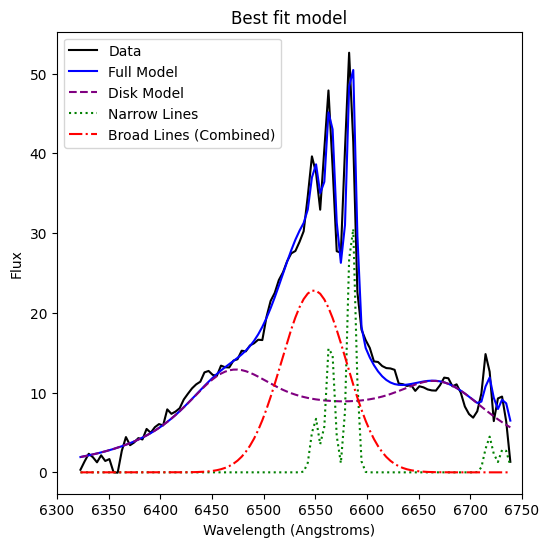

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(6,6))
plt.plot(wl / (1 + fixed['z']), flux, label='Data', color='black')
plt.plot(wl / (1 + fixed['z']), modelfit[0], label='Full Model', color='blue')
plt.plot(wl / (1 + fixed['z']), modelfit[1], label='Disk Model', linestyle='--', color='purple')
plt.plot(wl / (1 + fixed['z']), modelfit[2], label='Narrow Lines', linestyle=':', color='green')
plt.plot(wl / (1 + fixed['z']), modelfit[3], label='Broad Lines (Combined)', linestyle='-.', color='red')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.xlim(6300, 6750)
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

In [16]:
import emcee

#Distribute starting walkers to be very close to best-fit redshift but have more spread for disk parameters
#pos = np.column_stack((soln.x[:-1] + 5e-2 * soln.x[:-1] * np.random.randn(20, soln.x.shape[0]-1),soln.x[-1] + 1e-6 * soln.x[-1] * np.random.randn(20,1)))
pos = soln.x + 5e-6 * soln.x * np.random.randn(200, soln.x.shape[0])
#pos = np.column_stack((
#    soln.x[:5] + 5e-2 * soln.x[:5] * np.random.randn(200, 5),
#    soln.x[5:] + 1e-3 * soln.x[5:] * np.random.randn(200, soln.x.shape[0] - 5)
#))

nwalkers, ndim = pos.shape
filename ='emcee2.h5'
backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(None, 1760, progress=True)


100%|████████████████████████████████████| 1760/1760 [18:06:56<00:00, 37.05s/it]


State([[-7.31909937e+280  4.80481360e+281  1.06801284e+281 ... -3.44823385e+276
   9.41680125e+277 -2.11702749e+277]
 [ 3.60677656e+279 -2.36518168e+280 -5.29883928e+279 ...  1.86319053e+275
  -4.67288453e+276  1.04705617e+276]
 [-5.24551297e+280  3.44587670e+281  7.62211472e+280 ... -2.32370084e+276
   6.71976241e+277 -1.51382200e+277]
 ...
 [-5.92546350e+280  3.89421113e+281  8.58708719e+280 ... -2.51928579e+276
   7.56995615e+277 -1.70759944e+277]
 [-1.01614870e+281  6.67538116e+281  1.47638865e+281 ... -4.49457261e+276
   1.30160132e+278 -2.93238176e+277]
 [-9.69237655e+280  6.37403314e+281  1.39876769e+281 ... -3.85332281e+276
   1.23294817e+278 -2.78693846e+277]], log_prob=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0

In [47]:
from IPython.display import display, Math
#flat_samples = sampler.get_chain(discard=1500, flat=True)
flat_samples = sampler.get_chain(flat=True)[500:1500]
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    #display(Math(txt))

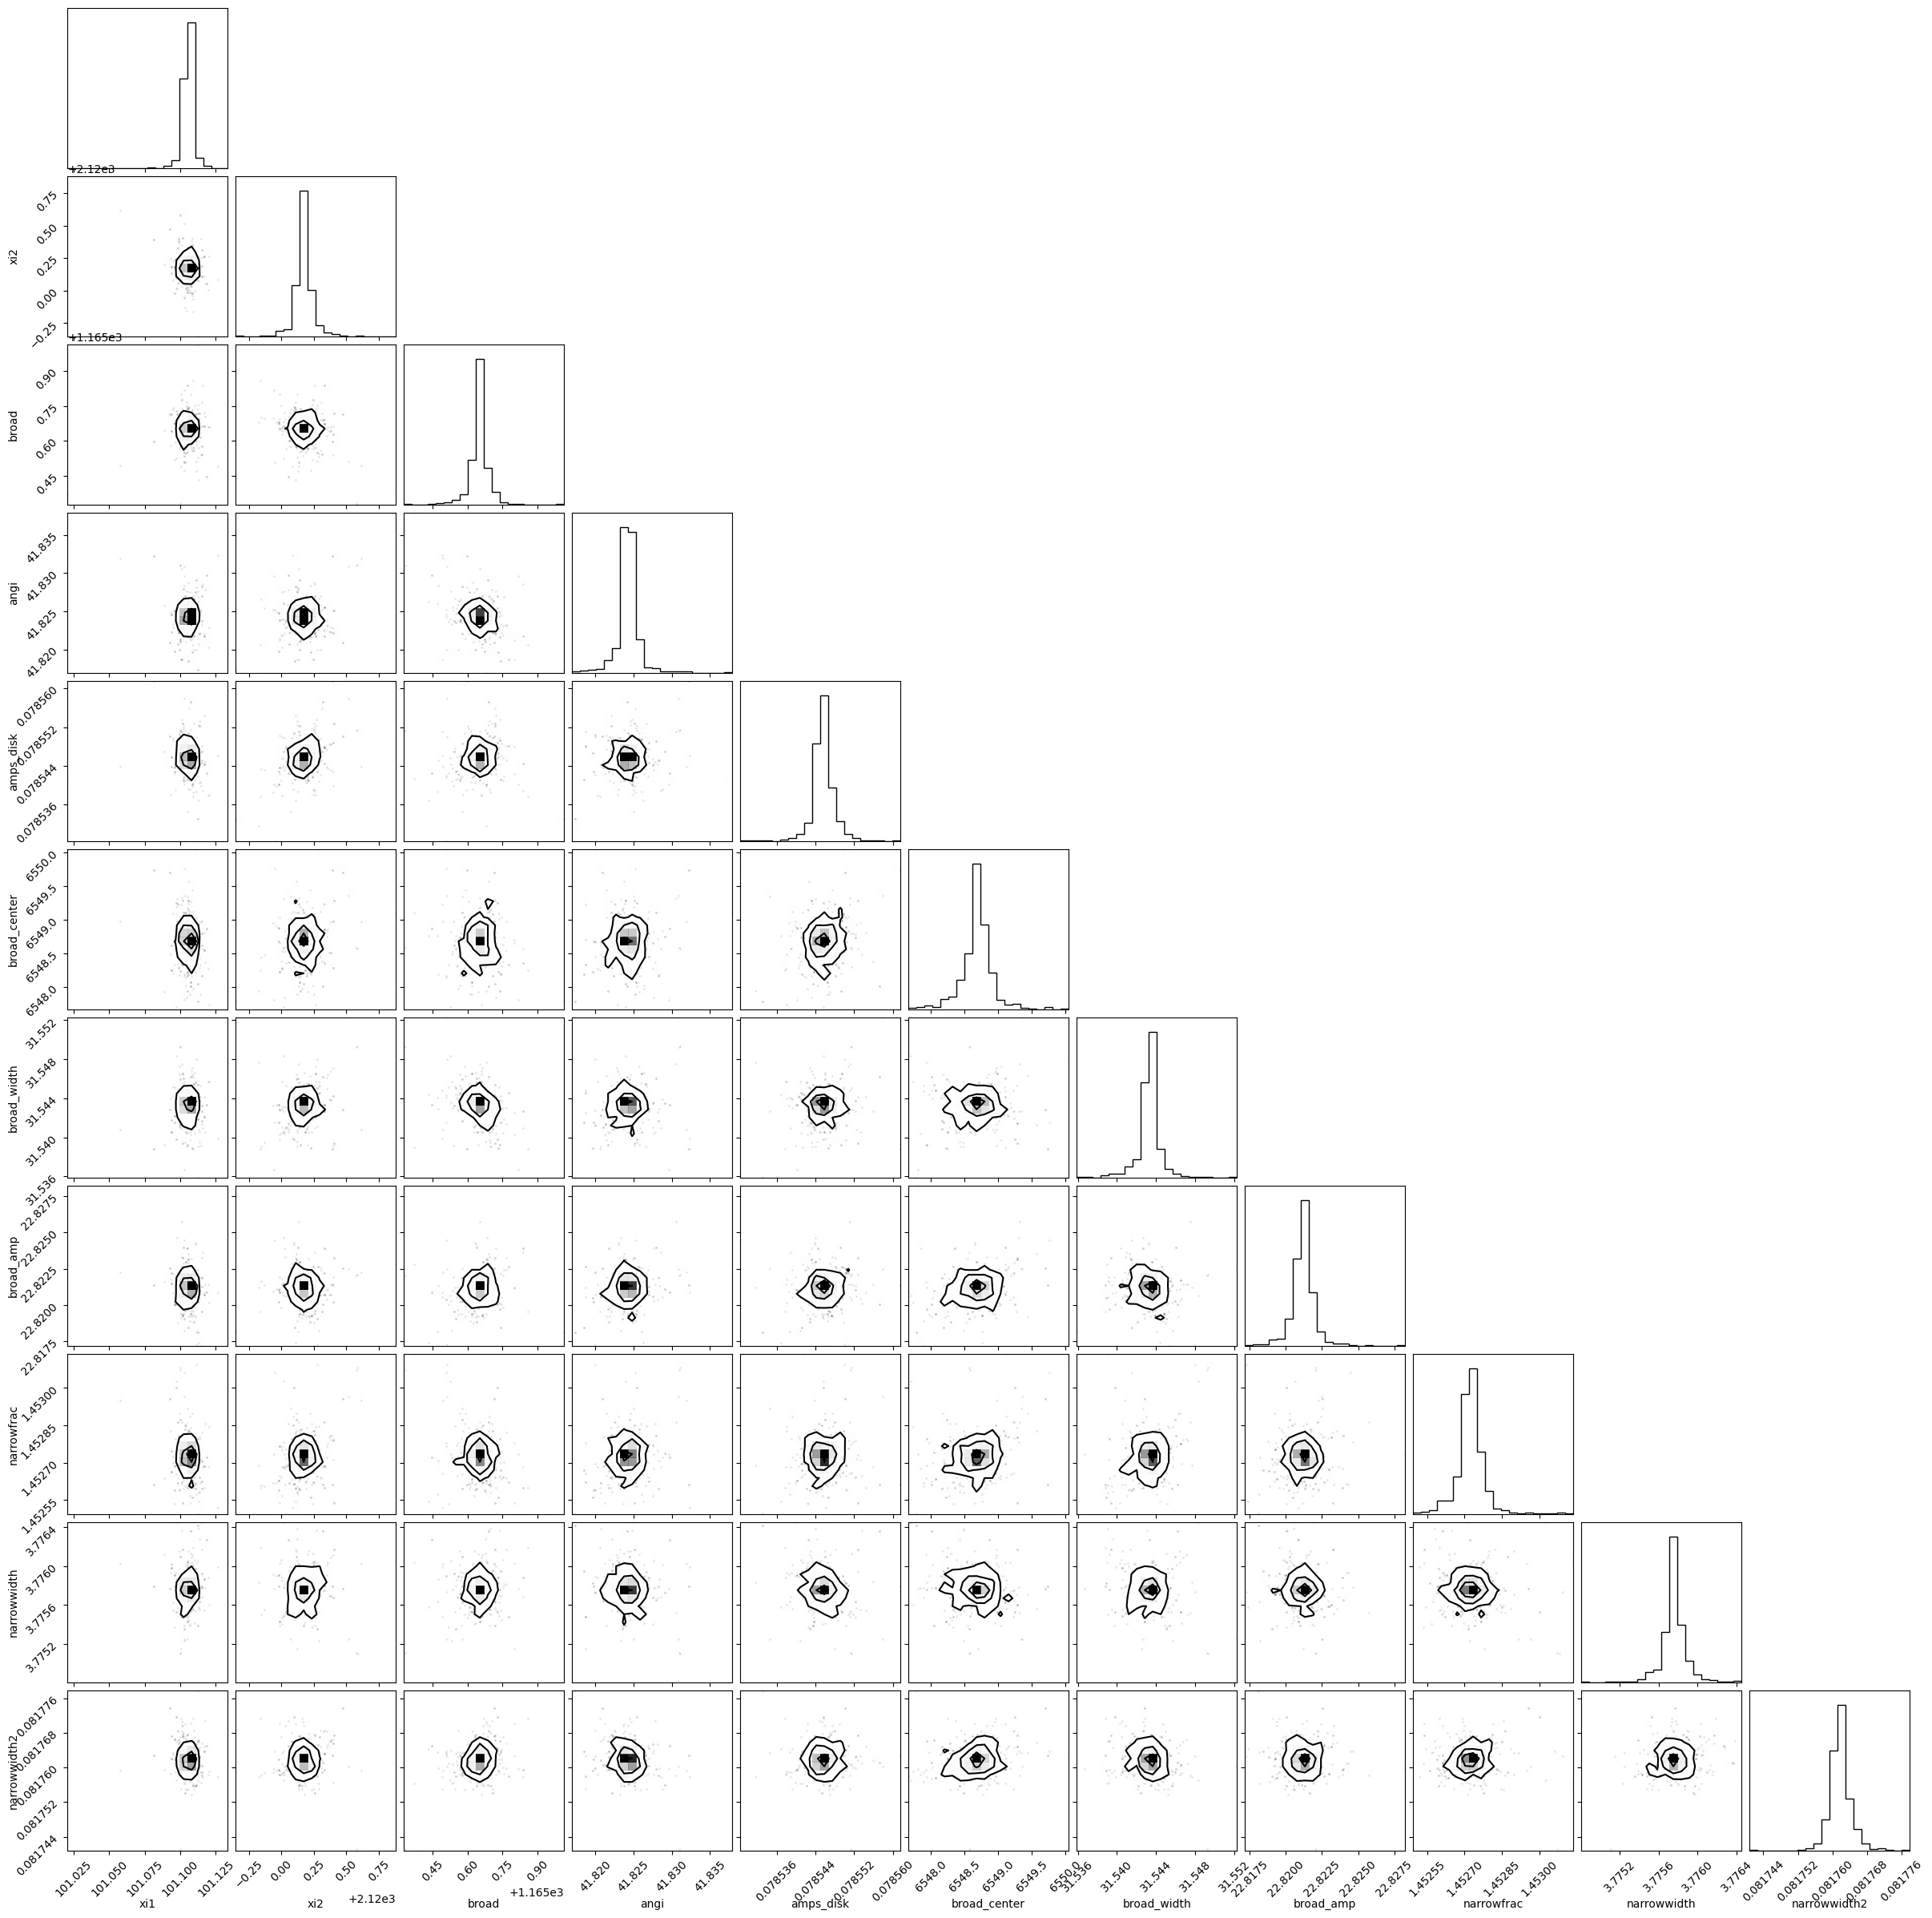

In [48]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

<Figure size 600x600 with 0 Axes>

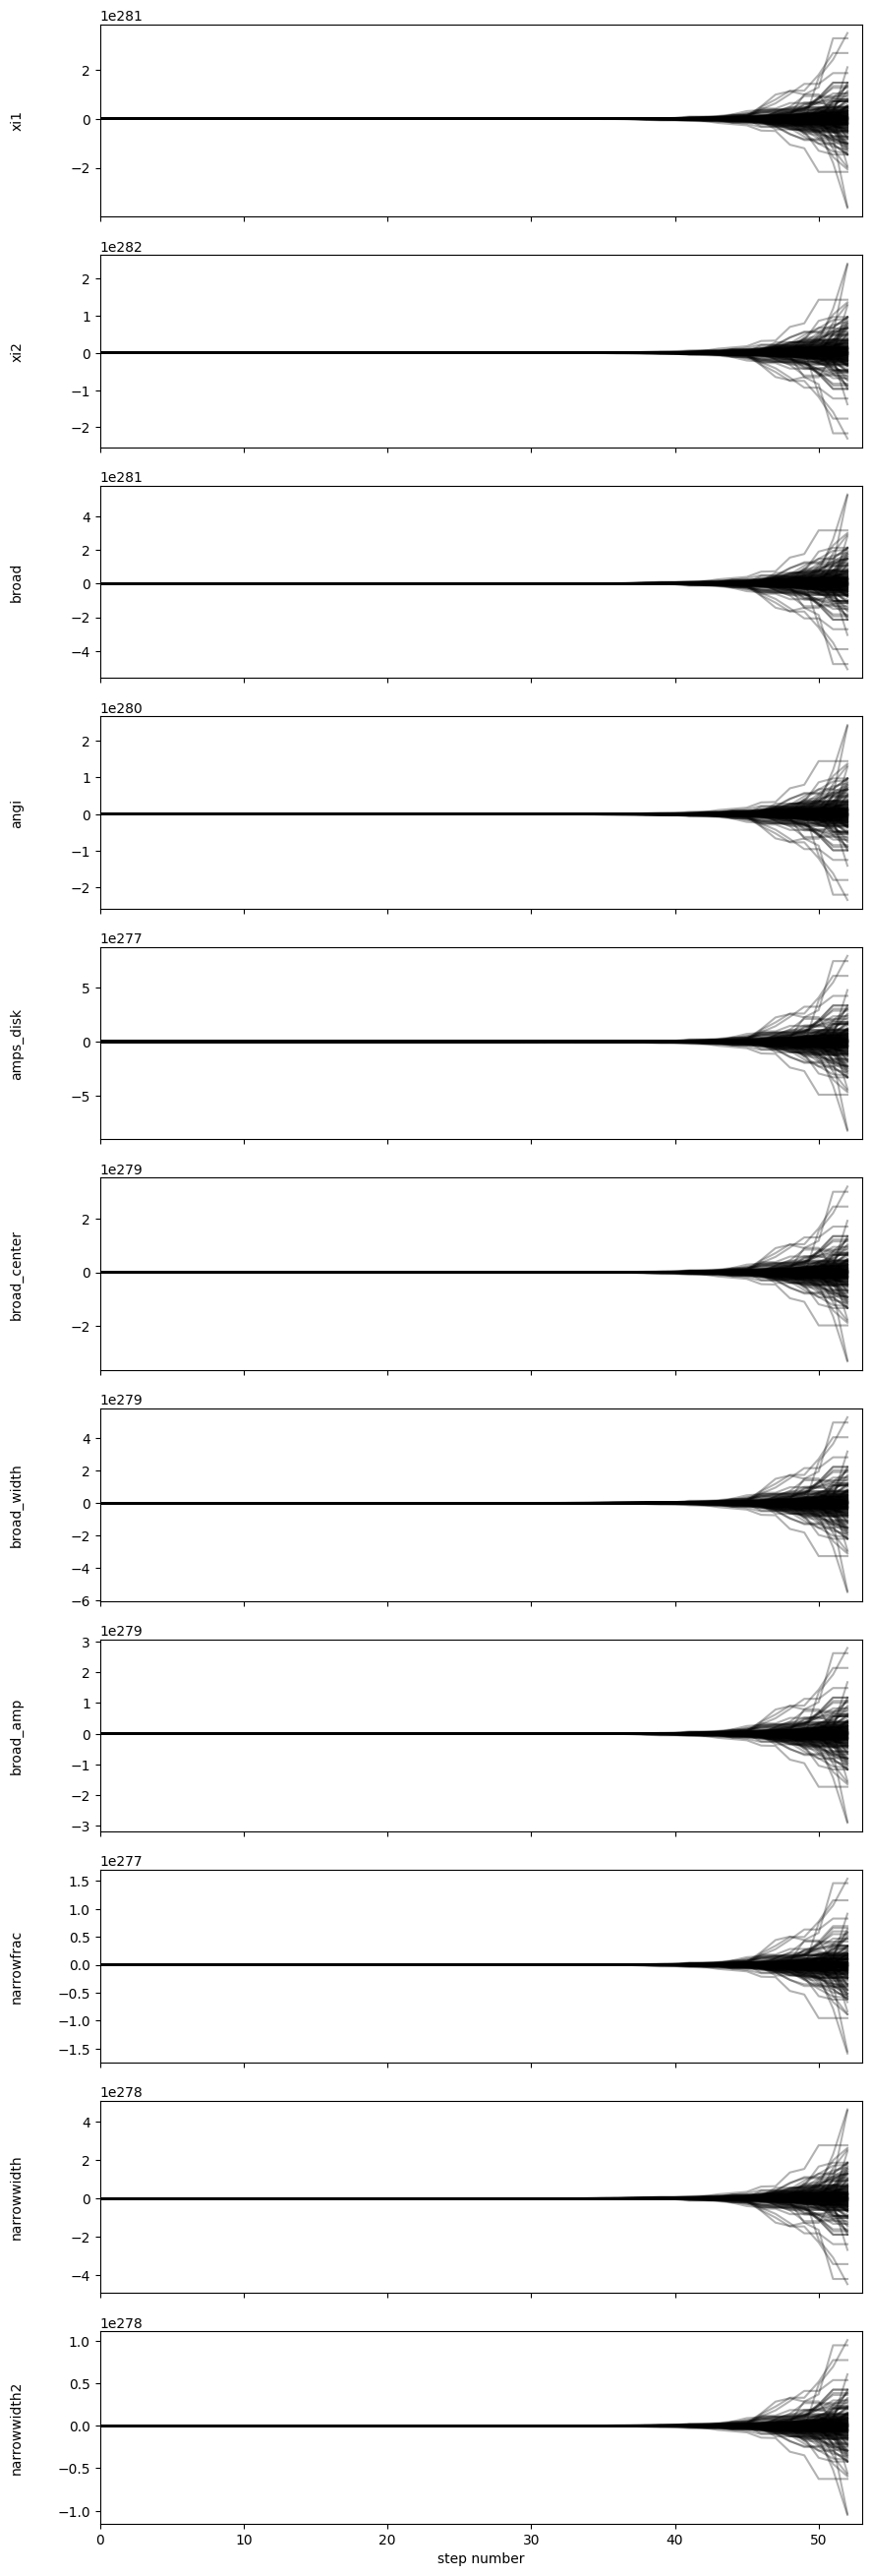

<Figure size 640x480 with 0 Axes>

In [49]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
#samples = sampler.get_chain()
samples = sampler.get_chain()[1950:]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

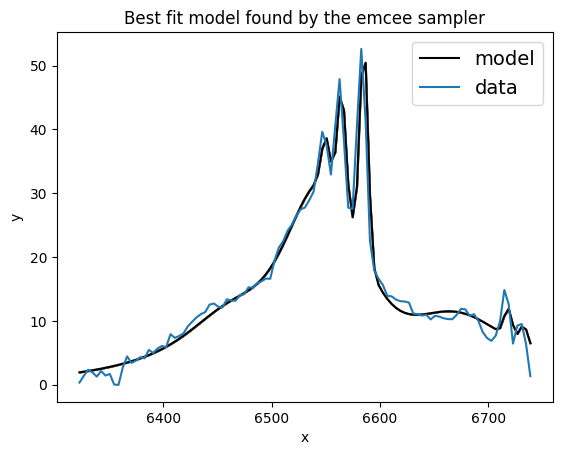

<Figure size 640x480 with 0 Axes>

In [53]:
from ultranest.plot import PredictionBand
band = PredictionBand(wl/(1+fixed['z']))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    modelfit, _, _, _ = lp.test(sample)
    band.add(modelfit)
    plt.plot(wl/(1+fixed['z']),modelfit,alpha=0.1)

band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()

# Plot for paper

In [105]:
wave = wl

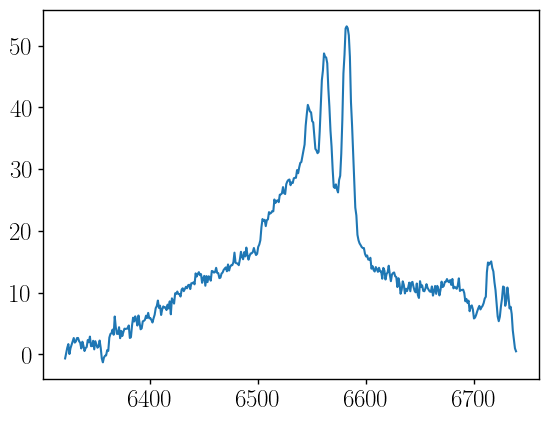

In [106]:
file_name = '/home/serat/Downloads/ticktock/bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 7500))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6015) | (wl_o > 6170))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130))
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]


coefficients = np.polyfit(wl, flux, 3)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

degree = 3

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o

file_path = '/home/serat/Downloads/ticktock/HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6320)&(source_wl<6740))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]

shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 1
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])


flux_halpha = source_flux / standard_flux
corrected_wl = bin_centers

rest_wavelength = 6564.93

c = 299792.458

vel_halpha = c * (corrected_wl - rest_wavelength) / rest_wavelength


pl = powerlaw(corrected_wl, 6.726822875, -0.9262954893 )

x = np.array(corrected_wl)

sii1 = gaussian(x,SII1_F0,SII1_CENT0,SII1_FWHM0,normalized=False)
sii2 = gaussian(x,SII2_F0,SII2_CENT0,SII2_FWHM0,normalized=False)

nii1 = gaussian(x,NII1_F0,NII1_CENT0,NII1_FWHM0,normalized=False)
nii2 = gaussian(x,NII2_F0,NII2_CENT0,NII2_FWHM0,normalized=False)

oi1 = gaussian(x,OI1_F0,OI1_CENT0,OI1_FWHM0,normalized=False)
oi2 = gaussian(x,OI2_F0,OI2_CENT0,OI2_FWHM0,normalized=False)

halpha = gaussian(x,HALPHA1_F0,HALPHA1_CENT0,HALPHA1_FWHM0,normalized=False)

npix = wl.shape[0]

flux_halpha = flux_halpha - pl #- (halpha + oi1 + oi2 + nii1 + nii2 + sii1 + sii2)
#narrow_lines = halpha + oi1 + oi2 + nii1 + nii2 + sii1 + sii2)

plt.plot(corrected_wl, flux_halpha)
plt.show()

In [107]:
blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

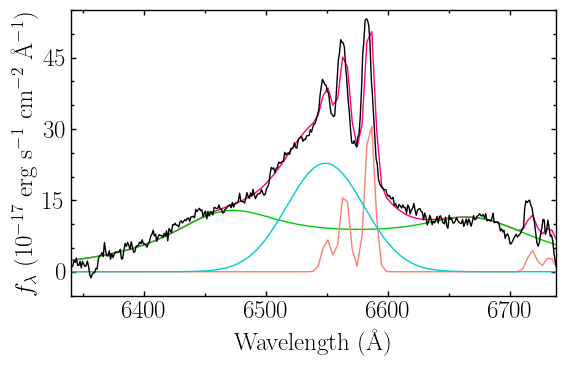

In [124]:
from ultranest.plot import PredictionBand
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
band = PredictionBand(wl / (1 + fixed['z']))
inds = np.random.randint(len(flat_samples), size=10)


plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 18,
    'axes.linewidth' :1
})
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

fig = plt.figure(figsize=(6, 4))
ax  = plt.axes()

sample = np.mean(flat_samples, axis=0)
modelfit, diskmodel, narrowmodel, broadmodel = lp.test(sample)

# Plotting the models without the error bands
ax.plot(wave / (1 + fixed['z']), modelfit, label='Full Model', linewidth=1, color=pink)
ax.plot(wave / (1 + fixed['z']), diskmodel, label='Disk Model', linewidth=1, color=green)
ax.plot(wave / (1 + fixed['z']), narrowmodel, label='Narrow Lines', linewidth=1, color=salmon)
ax.plot(wave / (1 + fixed['z']), broadmodel, label='Broad Lines (Combined)', linewidth=1, color=turquoise)

# Commented out the error band and shading to plot only spectra and components
# band.line(color='k', label='model')
# band.shade(color='k', alpha=0.5)
# band.shade(q=0.49, color='gray', alpha=0.2)

ax.plot(corrected_wl, flux_halpha, label='Data', linewidth=1, color='black')



ax.set_xlim(6340,6738)
ax.set_ylim(-5,55)
ax.set_xlabel('Wavelength (\AA)',size=18)
ax.set_ylabel('$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',size=18)

#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="both",which='both',direction="in")
plt.tight_layout()
plt.savefig('diskfit.pdf', format='pdf')
plt.show()


In [21]:
def model_linefit_circ_fixeddoublet(theta, w, y, yerr, lines, fixed, fitted):
    """
    Function which takes the wavelengths (w), fluxes (y), flux errors (yerr) of a spectrum, and a set of disk parameters (as well as redshift and narrow emission line width) distributed amongst two dictionaries (fitted and fixed). It will then calculate the circular disk model given the parameters, find the best fit amplitudes for the disk and the narrow lines, and return the full model as an array.
    Inputs
    theta: np.array containing updated fitted disk parameters (corresponding to the labels in the fitted dictionary)
    x: wavelengths (observed)
    y: measured fluxes
    yerr: flux uncertainties
    lines: list of narrow emission line wavelengths to be included in the model 
    fixed: dictionary of fixed disk parameters (parameter labels: parameter values)
    fitted: dictionary of fitted disk parameters (parameter labels: parameter values) The values in this dictionary will be updated to the array values carried in theta.

    Output:
    model: array of model fluxes corresponding to the input wavelengths
    """
    
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    M = np.empty((len(params['ratios'])+2,len(x)))
    M[0] = np.exp(-0.5*((x-lines[0])/(widths[0]))**2)
    for p,i in zip(range(len(params['ratios'])),np.arange(1,len(lines),2)):        
        M[p+1] = np.sum((np.exp(-0.5*((x-lines[i])/(widths[i]))**2),params['ratios'][p]*np.exp( (x-lines[i+1])**2 * (-0.5/widths[i+1]**2) )),axis=0)
    M[0] = np.sum((M[0]/params['narrowfrac'],np.exp(-0.5*((x-lines[0])/(widths[len(lines)]))**2)),axis=0)
    for p,i in zip(range(len(params['ratios'])),np.arange(len(lines)+1,2*len(lines),2)):        
        M[p+1] = np.sum((M[p+1]/params['narrowfrac'],np.exp(-0.5*((x-lines[1+2*p])/(widths[i]))**2),params['ratios'][p]*np.exp( (x-lines[1+2*p])**2 * (-0.5/widths[i+1]**2) )),axis=0)

    Cinv = np.eye(x.shape[0])*(1/yerr**2)
    M[-1] = diskmodel 
    lhs = M@Cinv@(y)
    rhs = M@Cinv@M.T
    rhs += np.eye(rhs.shape[0]) * 1e-6 
    amps = np.clip(np.linalg.solve(rhs,lhs),a_min=0.0, a_max=1e10) 
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:-1]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:-1]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    
    
    
    
    
    diskout = diskmodel*amps[-1]
    '''
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.ones(len(lines))*params['narrowwidth']
    lineprofs = utils.build_doublet_profiles(x,lines,params['narrowwidth'],params['ratios'])
    M = np.empty((len(params['ratios'])+2,len(x)))
    M[0] = np.exp(-0.5*((x-lines[0])/(widths[0]))**2)
    for p,i in zip(range(len(params['ratios'])),np.arange(1,len(widths),2)):
        M[p+1] = np.sum((np.exp(-0.5*((x-lines[i])/(widths[i]))**2),params['ratios'][p]*np.exp( (x-lines[i+1])**2 * (-0.5/widths[i+1]**2) )),axis=0)
    Cinv = np.eye(x.shape[0])*(1/yerr**2)
    M[-1] = diskmodel 
    lhs = M@Cinv@(y)
    rhs = M@Cinv@M.T
    rhs += np.eye(rhs.shape[0]) * 1e-6 
    amps = np.clip(np.linalg.solve(rhs,lhs),a_min=0.0, a_max=1e10) 
    narrowmodel = lineprofs[0] * amps[0]
    for line,amp in zip(lineprofs[1:],amps[1:-1]):
        narrowmodel+=line*amp 
    diskout = diskmodel*amps[-1]
    '''
    model = np.sum((diskout,narrowmodel),axis=0)
    return model

def model_linefit_circ_fixeddoublet_amplitudes(theta, w, y, yerr, lines, fixed, fitted):
    """
    Function which takes the wavelengths (w), fluxes (y), flux errors (yerr) of a spectrum, and a set of disk parameters (as well as redshift and narrow emission line width) distributed amongst two dictionaries (fitted and fixed). It will then calculate the circular disk model given the parameters, find the best fit amplitudes for the disk and the narrow lines, and return the full model as an array.
    Inputs
    theta: np.array containing updated fitted disk parameters (corresponding to the labels in the fitted dictionary)
    x: wavelengths (observed)
    y: measured fluxes
    yerr: flux uncertainties
    lines: list of narrow emission line wavelengths to be included in the model 
    fixed: dictionary of fixed disk parameters (parameter labels: parameter values)
    fitted: dictionary of fitted disk parameters (parameter labels: parameter values) The values in this dictionary will be updated to the array values carried in theta.

    Output:
    model: array of model fluxes corresponding to the input wavelengths
    """
    
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    M = np.empty((len(params['ratios'])+2,len(x)))
    M[0] = np.exp(-0.5*((x-lines[0])/(widths[0]))**2)
    for p,i in zip(range(len(params['ratios'])),np.arange(1,len(lines),2)):        
        M[p+1] = np.sum((np.exp(-0.5*((x-lines[i])/(widths[i]))**2),params['ratios'][p]*np.exp( (x-lines[i+1])**2 * (-0.5/widths[i+1]**2) )),axis=0)
    M[0] = np.sum((M[0]/params['narrowfrac'],np.exp(-0.5*((x-lines[0])/(widths[len(lines)]))**2)),axis=0)
    for p,i in zip(range(len(params['ratios'])),np.arange(len(lines)+1,2*len(lines),2)):        
        M[p+1] = np.sum((M[p+1]/params['narrowfrac'],np.exp(-0.5*((x-lines[1+2*p])/(widths[i]))**2),params['ratios'][p]*np.exp( (x-lines[1+2*p])**2 * (-0.5/widths[i+1]**2) )),axis=0)

    Cinv = np.eye(x.shape[0])*(1/yerr**2)
    M[-1] = diskmodel 
    lhs = M@Cinv@(y)
    rhs = M@Cinv@M.T
    rhs += np.eye(rhs.shape[0]) * 1e-6 
    amps = np.clip(np.linalg.solve(rhs,lhs),a_min=0.0, a_max=1e10)
    return amps[:-1],amps[-1]
